# Simple PINN for an elastic plate with a hole 

## Generating the data and build the neural network



In [ ]:
import torch
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import random
from math import pi, ceil
from plate_elliptic_hole import Plate 

# Applied strain at right boundary
EPS0 = 0.1
# Applied body force field
B0 = 0.0
# Lame constants
MU = 1
LBD = 2

Ra_x = 0.7 #radius on the x-axis of the ellipse 
SuAr= 0.25*pi   #surface area of the eclipse (= equal to SuAr of a circle with R=0.5)
Min_Ra_x = 0.25
Max_Ra_x = 0.8
# Min_Ra_x_train = 0.5 #minimal radius on the x-axis of the ellipse
# Max_Ra_x_train = 0.8 #maximum radius on the x-axis of the ellipse
# Min_Ra_x_test = 0.25 #minimal radius on the x-axis of the ellipse
# Max_Ra_x_test = 0.5 #maximum radius on the x-axis of the ellipse

L = 1 #length of plate #info: muss noch gefixt werden -> momentan bei 1 lassen
N = 15 #15 #number of collocation Point in x-axis direction
P = 20 #number of plates in dataset
NN = ceil(N * (L-Ra_x)/L) #number of collocation Point in both direction

def generate_radii_list(iteration, min_Ra_x, max_Ra_x):
    rad_x_list = np.linspace(min_Ra_x, max_Ra_x, iteration)
    rad_y_list = []
    for rad_x in rad_x_list:
        rad_y_list.append(SuAr/(pi*rad_x))
    return rad_x_list, rad_y_list

def generate_multiple_plates_dict(iteration, min_Ra_x, max_Ra_x):
    dict_plate_points = dict()
    tuples = [
            ("x_collo", 0, 0),
            ("y_collo", 0, 1),
            ("r_collo", 0, 2),
            ("x_top", 1, 0),
            ("y_top", 1, 1),
            ("r_top", 1, 2),
            ("x_right", 2, 0),
            ("y_right", 2, 1),
            ("r_right", 2, 2),
            ("x_left", 3, 0),
            ("y_left", 3, 1),
            ("r_left", 3, 2),
            ("x_bottom", 4, 0),
            ("y_bottom", 4, 1),
            ("r_bottom", 4, 2),
            ("x_hole", 5, 0),
            ("y_hole", 5, 1),
            ("n_hole", 5, 2),
            ("r_hole", 5, 3),
            
        ] 
    
    ra_x_list, ra_y_list = generate_radii_list(iteration, min_Ra_x, max_Ra_x)
    for i in range(iteration):
        p1 = Plate(Ra_x, SuAr, L, N)
        data_one_plate = p1.generate_dataset_new(ra_x_list[i], ra_y_list[i], L, N)
        for tuple in tuples:
            key = tuple[0]
            dict_plate_points.setdefault(key, []).append(data_one_plate[tuple[1]][tuple[2]])
        #p1.plot_plate_with_hole(*data_one_plate)
    for key in dict_plate_points: 
        #print(key, "  ",dict_plate_points[key])
        #appending list of tensors to one tensor
        dict_plate_points[key] = torch.cat(dict_plate_points[key])
        if(key is not str("n_hole")):
            dict_plate_points[key] = torch.flatten(dict_plate_points[key])
        #print(key, "  ",dict_plate_points[key])
        #print(key, "shape is", dict_plate_points[key].size())
    #print(dict_plate_points)
    #print("Der Datensatz besteht aus",dict_plate_points["x_collo"].size(), "Datenpunkten" )
    #print("Der Datensatz besteht aus",dict_plate_points["y_collo"].size(), "Datenpunkten" )
    #print("Der Datensatz besteht aus",dict_plate_points["r_collo"].size(), "Datenpunkten" )
    collo_points = torch.column_stack([dict_plate_points["x_collo"], dict_plate_points["y_collo"], dict_plate_points["r_collo"]])
    top_points = torch.column_stack([dict_plate_points["x_top"], dict_plate_points["y_top"], dict_plate_points["r_top"]])
    right_points = torch.column_stack([dict_plate_points["x_right"], dict_plate_points["y_right"], dict_plate_points["r_right"]])
    left_points = torch.column_stack([dict_plate_points["x_left"], dict_plate_points["y_left"], dict_plate_points["r_left"]])
    bottom_points = torch.column_stack([dict_plate_points["x_bottom"], dict_plate_points["y_bottom"], dict_plate_points["r_bottom"]])
    hole_points = torch.column_stack([dict_plate_points["x_hole"], dict_plate_points["y_hole"], dict_plate_points["r_hole"]])
    n_hole = dict_plate_points["n_hole"]

    #shuffle points random
    collo_points = collo_points[torch.randperm(collo_points.size()[0])]
    top_points = top_points[torch.randperm(top_points.size()[0])]
    right_points = right_points[torch.randperm(right_points.size()[0])]
    left_points = left_points[torch.randperm(left_points.size()[0])]
    bottom_points = bottom_points[torch.randperm(bottom_points.size()[0])]
    hole_points = hole_points[torch.randperm(hole_points.size()[0])]


    return collo_points, top_points, right_points, left_points, bottom_points, hole_points, n_hole


p2 = Plate(Ra_x, SuAr, L, N)
Re_xnew, Re_ynew = p2.create_ellipse(Ra_x,SuAr, L)
#p2.plot_quarter_elli(Re_xnew, Re_ynew)
train_plates_data = generate_multiple_plates_dict(P, Min_Ra_x, Max_Ra_x)
test_plates_data = generate_multiple_plates_dict(P,Min_Ra_x, Max_Ra_x)
#print("Der Datensatz besteht aus", train_plates_data[1].shape, "Datenpunkten" )

#data_train_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
#data_test_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
#p2.plot_plate_with_hole_old(*data_train_points)
#p2.plot_plate_with_hole(*data_test_points)


In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hn = 20
        self.hidden_layer1 = torch.nn.Linear(3,hn)
        self.hidden_layer2 = torch.nn.Linear(hn,hn)
        self.hidden_layer3 = torch.nn.Linear(hn,hn)
        self.hidden_layer4 = torch.nn.Linear(hn,hn)
        self.hidden_layer5 = torch.nn.Linear(hn,hn)
        self.output_layer = torch.nn.Linear(hn,2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the PDE 
$$
    \nabla \cdot \sigma - \mathbf{b} = \mathbf{0}. 
$$

In [4]:
def sigma(eps):
    I = torch.eye(2)
    return 2.0 * MU * eps + LBD * torch.einsum("...ii,...jk->...jk", eps, I)

def epsilon(x, y, r, net):
    inputs = torch.column_stack([x,y,r])
    disp = net(inputs)
    u = disp[:,0]
    v = disp[:,1]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

    gradx = torch.column_stack([u_x, v_x])
    grady = torch.column_stack([u_y, v_y])
    gradient = torch.stack([gradx, grady], dim=2)

    return 0.5 * (gradient + torch.transpose(gradient, 1, 2))

def pde_residual(x, y, r, net):
    stress = sigma(epsilon(x,y,r, net))
    sxx = stress[:,0,0]
    sxy = stress[:,0,1]
    syx = stress[:,1,0]
    syy = stress[:,1,1]
    

    sxx_x = torch.autograd.grad(sxx.sum(), x, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy.sum(), y, create_graph=True)[0]
    syx_x = torch.autograd.grad(syx.sum(), x, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy.sum(), y, create_graph=True)[0]

    residual_x = sxx_x + sxy_y - B0
    residual_y = syx_x + syy_y
    return residual_x, residual_y


## The loss function

In [5]:
W_PDE = 0.01
W_NEUMANN = 0.01

mse = torch.nn.MSELoss()


def compute_loss(net, collo_points, top_points, right_points, left_points, bottom_points, hole_points, n_hole):

    # pde
    res_x, res_y = pde_residual(collo_points[:,0],collo_points[:,1],collo_points[:,2], net)
    zeros = torch.zeros_like(res_x)
    pde_error = mse(res_x, zeros) + mse(res_y, zeros)

    # left boundary
    pred_left = net(left_points)
    bc_left = torch.zeros_like(pred_left[:,0])
    left_error = mse(pred_left[:,0], bc_left) 

    # right boundary
    pred_right = net(right_points)
    bc_right = EPS0 * L * torch.ones_like(pred_right[:,0])
    right_error = mse(pred_right[:,0], bc_right) 

    # bottom boundary
    pred_bottom = net(bottom_points)
    bc_bottom = torch.zeros_like(pred_bottom[:,1])
    bottom_error = mse(pred_bottom[:,1], bc_bottom) 

    # top boundary
    stress_top = sigma(epsilon(top_points[:,0],top_points[:,1],top_points[:,2], net))
    zeros = torch.zeros_like(stress_top[:,1,1])
    top_error = mse(stress_top[:,1,1], zeros) + mse(stress_top[:,0,1], zeros)

    # hole boundary
    stress_hole = sigma(epsilon(hole_points[:,0], hole_points[:,1], hole_points[:,2], net))
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:,0])
    hole_error = mse(traction[:,0], zeros) + mse(traction[:,1], zeros)

    return (
        left_error
        + right_error
        + bottom_error
        + W_NEUMANN * top_error
        + W_NEUMANN * hole_error
        + W_PDE * pde_error
    )


## Training 

In [6]:
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

net = Net()
train_data = []
test_data = []
epochs = 10000
iterations = 4
epochs_per_iter = int(epochs/iterations)
LeRa = 0.01
gamma = 0.3
batch_size = 4



#""""
optimizer = torch.optim.Adam(net.parameters(), LeRa)
scheduler = StepLR(optimizer, step_size=epochs_per_iter, gamma= gamma)
#train_data_loader = DataLoader(train_plates_data, batch_size = 7)
#print(train_data_loader.dataset[6])
#scheduler = ExponentialLR(optimizer, gamma=0.9)


#print("dataset: N:", N, "plates:", P)
#print("starting learning rate:", LeRa, "and gamma:", gamma, ", epochs:", epochs, "iterations:", iterations)
# for epoch in range(epochs):
#     for i in range(batch_size):
#         #print("batch nr", i+1)
#         train_plates_data_batch = []
#         test_plates_data_batch = []
#         for data in train_plates_data:
#             train_plates_data_batch.append(data[i+1::batch_size])
#         for data in test_plates_data:
#             test_plates_data_batch.append(data[i+1::batch_size])
#             #print(len(data))
#             #print(len(data[i+1::batch_size]))
#             #print(len(train_plates_data_batch))
#         optimizer.zero_grad()
#         #old code
#         #loss_train = compute_loss(net, *train_plates_data.values(), rad_x)
#         #loss_test = compute_loss(net, *test_plates_data.values(), rad_x)
#         #new code
#         loss_train = compute_loss(net, *train_plates_data_batch)
#         loss_test = compute_loss(net, *test_plates_data_batch)
#         loss_train.backward(retain_graph=True)
#         optimizer.step()
#         scheduler.step()
#         #print(scheduler.get_lr())
#         with torch.autograd.no_grad():
#             train_data.append(float(loss_train.data))
#             test_data.append(float(loss_test.data)) 


print("dataset: N:", N, "plates:", P)
print("starting learning rate:", LeRa, "and gamma:", gamma, ", epochs:", epochs, "iterations:", iterations)
for epoch in range(epochs):
    optimizer.zero_grad()
    #old code
    #loss_train = compute_loss(net, *train_plates_data.values(), rad_x)
    #loss_test = compute_loss(net, *test_plates_data.values(), rad_x)
    #new code
    loss_train = compute_loss(net, *train_plates_data)
    loss_test = compute_loss(net, *test_plates_data)
    loss_train.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    #print(scheduler.get_lr())
    with torch.autograd.no_grad():
        train_data.append(float(loss_train.data))
        test_data.append(float(loss_test.data)) 


plt.plot(train_data, c='g', label='train', linewidth=5.0)
plt.plot(test_data, c='r', label='test')
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()




dataset: N: 15 plates: 20
starting learning rate: 0.01 and gamma: 0.3 , epochs: 10000 iterations: 4


## Visualization of results

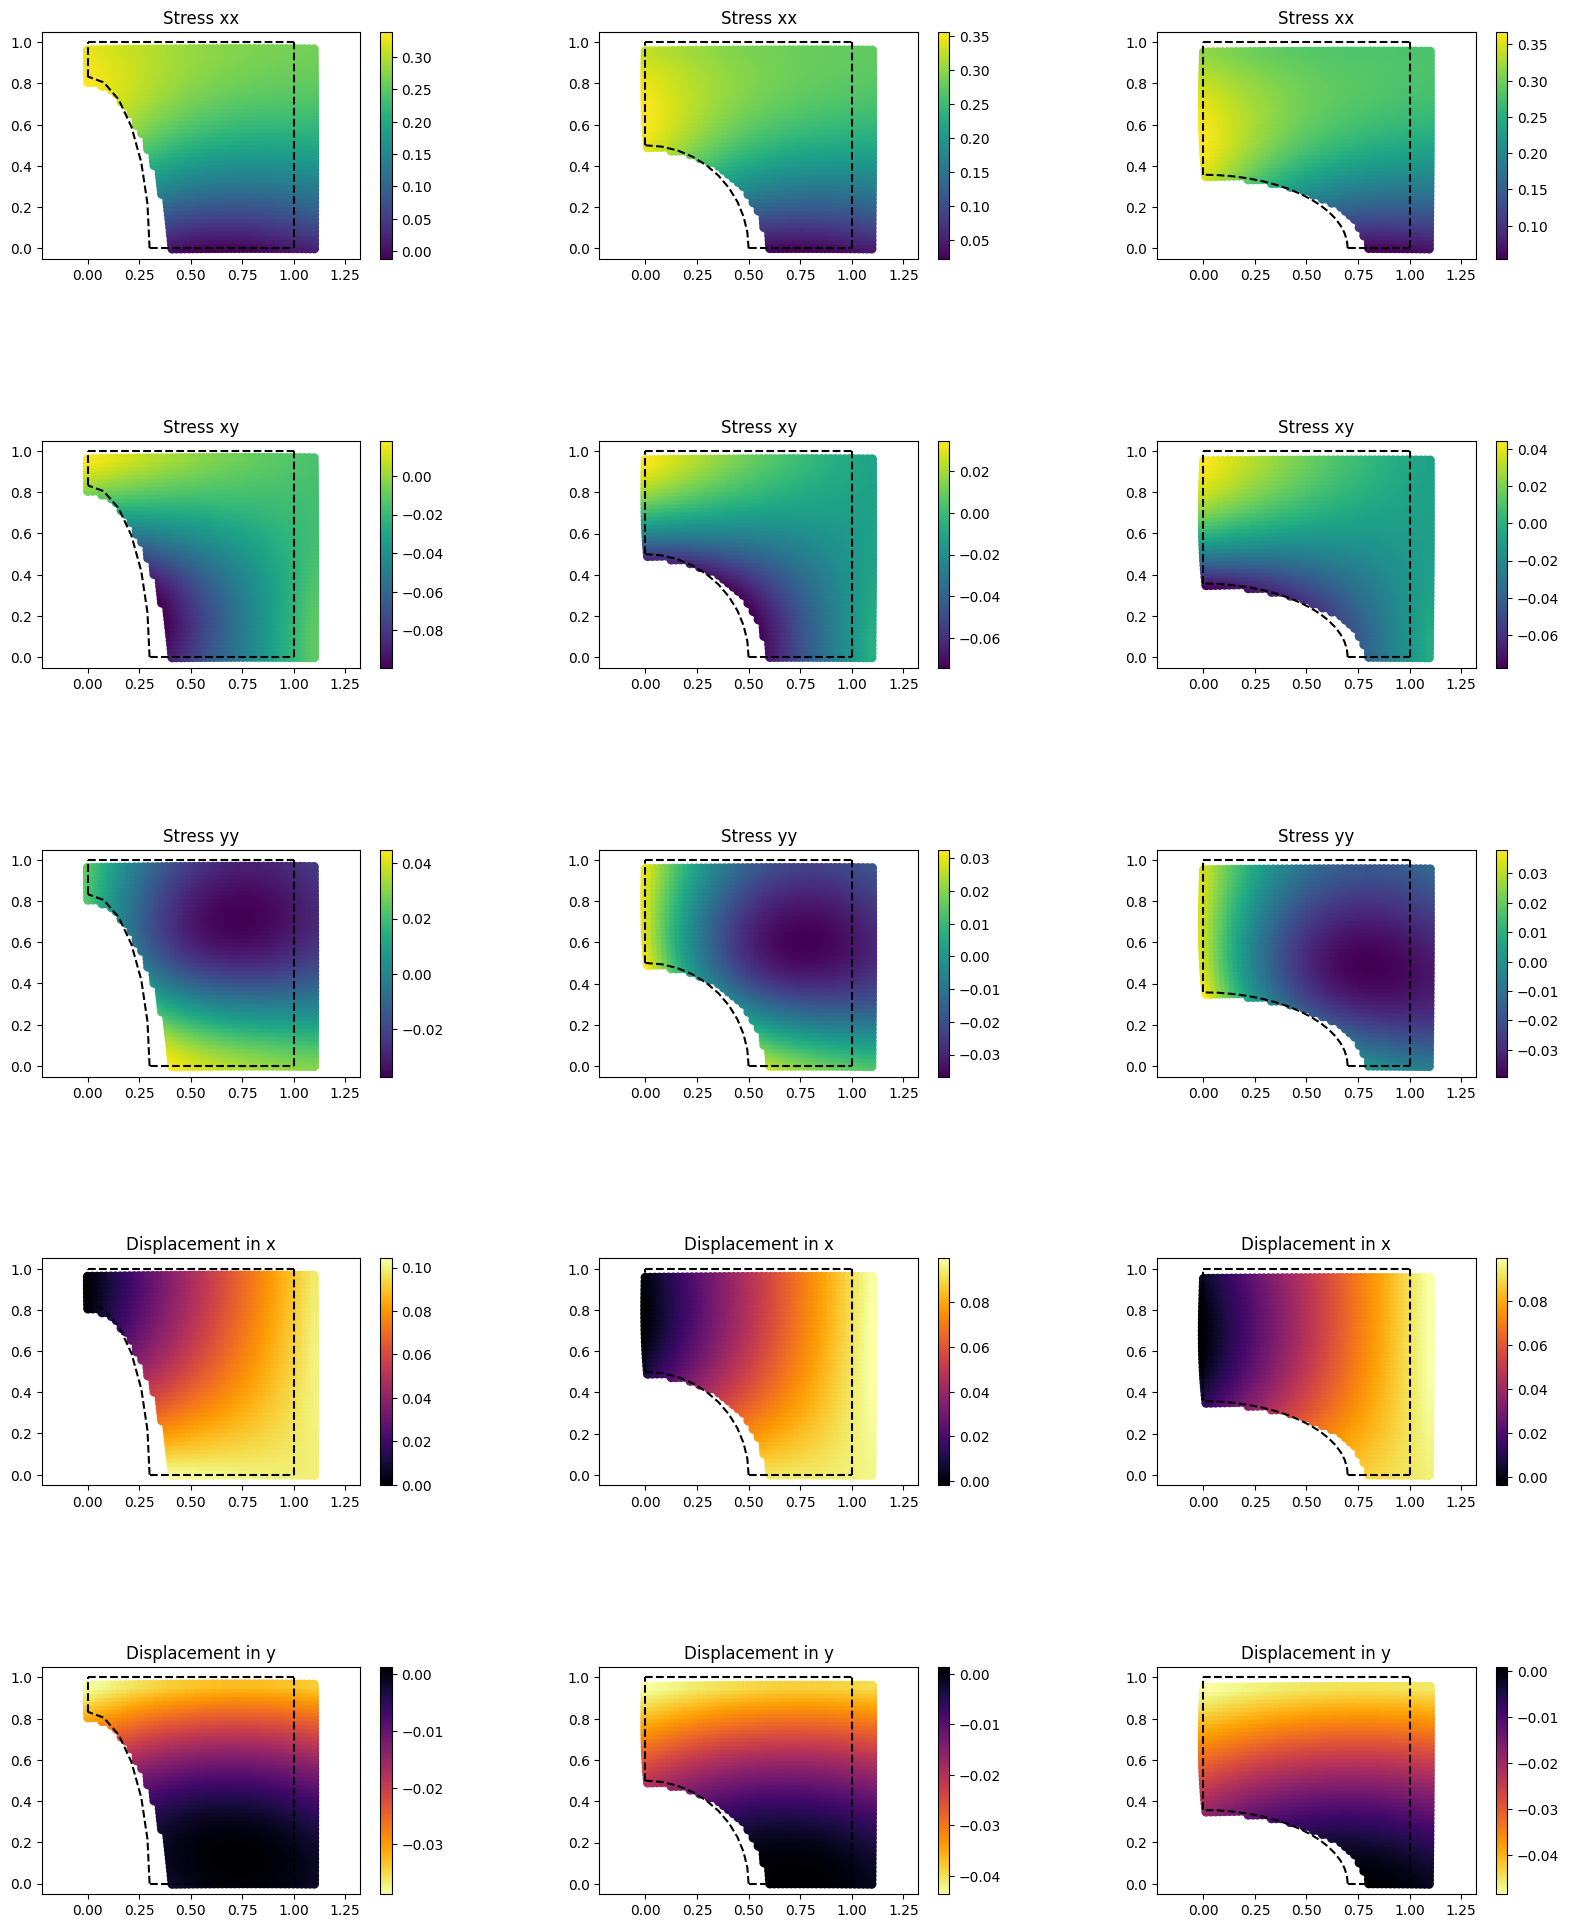

In [ ]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_r = np.linspace(Min_Ra_x, Max_Ra_x, 2500)
val_ry = val_r
for i in range(2500):
    val_ry[i] = (SuAr/(pi*val_r[i])) 
val_domain = np.vstack([val_x.ravel(), val_y.ravel(), val_r, val_ry]).T
#oldcode
#val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_xnew**2)) + ((val_domain[:,1] ** 2)/(Re_ynew**2)) > 1]
#newcode
val_domain = val_domain[((val_domain[:,0] ** 2)/(0.0001**2)) + ((val_domain[:,1] ** 2)/(0.0001**2)) > 1]
val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()
val_r = torch.tensor(val_domain[:,1], requires_grad=True).float()


def delete_points_inside_the_hole(val_domain, Re_x, Re_y):
    val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_x**2)) + ((val_domain[:,1] ** 2)/((Re_y)**2)) > 1]
    val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
    val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()
    return val_x, val_y

def compute_model_prediction(val_x, val_y, radius):
    inputs = torch.column_stack([val_x, val_y, radius])
    disp = net(inputs).detach()
    def_val_x = val_x.detach() + disp[:, 0]
    def_val_y = val_y.detach()+ disp[:, 1]
    strain = epsilon(val_x, val_y, radius, net).detach()
    stress = sigma(strain).detach()
    residual_x, residual_y = pde_residual(val_x, val_y, radius, net)
    return def_val_x, def_val_y, residual_x, residual_y, disp, stress


def create_subplot(def_val_x,def_val_y,variable, title, cmap, boundary_points):
    #top 
    plt.plot(boundary_points[0].detach(), boundary_points[1].detach(), "--k")
    #right
    plt.plot(boundary_points[2], boundary_points[3], "--k")
    #bottom
    plt.plot(boundary_points[6], boundary_points[7], "--k")
    #left
    plt.plot(boundary_points[4], boundary_points[5], "--k")
    #hole
    plt.plot(boundary_points[8].detach(), boundary_points[9].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, cmap=cmap)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)
    
    
def create_subplot_new(def_val_x,def_val_y,variable, title, cmap, __, top_points, right_points, left_points, bottom_points, hole_points):
    #top 
    plt.plot(top_points[0].detach(), top_points[1].detach(), "--k")
    #right
    plt.plot(right_points[0], right_points[1], "--k")
    #bottom
    plt.plot(bottom_points[0], bottom_points[1], "--k")
    #left
    plt.plot(left_points[0], left_points[1], "--k")
    #hole
    plt.plot(hole_points[0].detach(), hole_points[1].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, cmap=cmap)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)

def create_plot():

    radii = [
        (0.3, 0.8333333333333334),
        (0.5, 0.5),
        (0.7, 0.35714285714285715)
    ]

    for j in range(3):
        k = j+1
        new_val_x, new_val_y = delete_points_inside_the_hole(val_domain, radii[j][0], radii[j][1])
        new_val_r =  radii[j][0]*torch.ones_like(new_val_x)
        new_def_val_x, new_def_val_y, _, _, disp, stress = compute_model_prediction(new_val_x, new_val_y, new_val_r)

        tuples = [
            (stress[:, 0, 0], "Stress xx", "viridis"),
            (stress[:, 0, 1], "Stress xy", "viridis"),
            (stress[:, 1, 1], "Stress yy", "viridis"), 
            (disp[:, 0], "Displacement in x", "inferno"),
            (disp[:, 1], "Displacement in y", "inferno_r")
        ] 
        for i in range(5):
            plt.subplot(5,3,k)
            k += 3 
            p1 = Plate(*radii[j], L, P)
            data_points = p1.generate_dataset_new(*radii[j], L, N)
            create_subplot_new(new_def_val_x,new_def_val_y,*tuples[i],*data_points)
            #old code
            #data_points = p1.generate_dataset_test(*radii[j], L, N)
            #create_subplot(new_def_val_x,new_def_val_y,*tuples[i],data_points[1])
    plt.subplots_adjust(top = 3.99, right = 2.49, hspace=0.8, wspace=0.4)
    #plt.suptitle("Validation with different radius")
    plt.show


create_plot()



## Comparison of maximum stress at hole to high resolution FEM data

In [ ]:
# FEM solution with 74745 elements
r_data = torch.tensor([0.300, 0.350, 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800], requires_grad=True)
s_data = torch.tensor([1.615, 1.259, 1.047, 0.896, 0.776, 0.743, 0.845, 0.950, 1.062, 1.182, 1.315])
plt.plot(r_data.detach(), s_data, "ok")

# Evaluate stress with PINN at upper point in hole P1
r_opti = torch.linspace(0.3, 0.8, 100, requires_grad=True)
x_opti = torch.zeros_like(r_opti, requires_grad=True)
y_opti = 0.25 / r_opti
s_opti = sigma(epsilon(x_opti, y_opti, r_opti, net))
plt.plot(r_opti.detach(), s_opti[:,0,0].detach(), "k")

# Evaluate stress with PINN at upper point in hole P2
r_opti = torch.linspace(0.3, 0.8, 100, requires_grad=True)
x_opti = 0.25 / r_opti
y_opti = torch.zeros_like(r_opti, requires_grad=True)
s_opti = sigma(epsilon(x_opti, y_opti, r_opti, net))
plt.plot(r_opti.detach(), -s_opti[:,1,1].detach(), "k")

# Plot style
plt.legend(["PINN P1", "PINN P2", "FEM"])
plt.xlabel("Radius r_1")
plt.ylabel("Stress σ_11(x0)")
plt.grid()